# **I. Import Libraries**

In [1]:
!pip install networkx
!pip install ipywidgets

In [2]:
# Import các thư viện
import numpy as np
import gymnasium as gym
from gymnasium import spaces
from sklearn.preprocessing import LabelEncoder
import os
import csv

from stable_baselines3 import PPO
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.callbacks import EvalCallback

# Đảm bảo thư mục đầu ra
os.makedirs('/kaggle/working/deepq_outputs/', exist_ok=True)

/usr/local/lib/python3.11/dist-packages/gymnasium/envs/registration.py:596: UserWarning: WARN: plugin: shimmy.registration:register_gymnasium_envs raised Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/gymnasium/envs/registration.py", line 594, in load_plugin_envs
    fn()
  File "/usr/local/lib/python3.11/dist-packages/shimmy/registration.py", line 304, in register_gymnasium_envs
    _register_atari_envs()
  File "/usr/local/lib/python3.11/dist-packages/shimmy/registration.py", line 205, in _register_atari_envs
    import ale_py
  File "/usr/local/lib/python3.11/dist-packages/ale_py/__init__.py", line 68, in <module>
    register_v0_v4_envs()
  File "/usr/local/lib/python3.11/dist-packages/ale_py/registration.py", line 179, in register_v0_v4_envs
    _register_rom_configs(legacy_games, obs_types, versions)
  File "/usr/local/lib/python3.11/dist-packages/ale_py/registration.py", line 64, in _register_rom_configs
    gymnasium.register(
    ^^^^^^^^^^^

# **II. Environment**

In [3]:
class Robot: 
    def __init__(self, position): 
        self.position = position
        self.carrying = 0

class Package: 
    def __init__(self, start, start_time, target, deadline, package_id): 
        self.start = start
        self.start_time = start_time
        self.target = target
        self.deadline = deadline
        self.package_id = package_id
        self.status = 'None' # Possible statuses: 'waiting', 'in_transit', 'delivered'

class Environment: 

    def __init__(self, map_file, max_time_steps = 100, n_robots = 5, n_packages=20,
             move_cost=-0.01, delivery_reward=10., delay_reward=1., 
             seed=2025): 
        """ Initializes the simulation environment. :param map_file: Path to the map text file. :param move_cost: Cost incurred when a robot moves (LRUD). :param delivery_reward: Reward for delivering a package on time. """ 
        self.map_file = map_file
        self.grid = self.load_map()
        self.n_rows = len(self.grid)
        self.n_cols = len(self.grid[0]) if self.grid else 0 
        self.move_cost = move_cost 
        self.delivery_reward = delivery_reward 
        self.delay_reward = delay_reward
        self.t = 0 
        self.robots = [] # List of Robot objects.
        self.packages = [] # List of Package objects.
        self.total_reward = 0

        self.n_robots = n_robots
        self.max_time_steps = max_time_steps
        self.n_packages = n_packages

        self.rng = np.random.RandomState(seed)
        self.reset()
        self.done = False
        self.state = None

    def load_map(self):
        """
        Reads the map file and returns a 2D grid.
        Assumes that each line in the file contains numbers separated by space.
        0 indicates free cell and 1 indicates an obstacle.
        """
        grid = []
        with open(self.map_file, 'r') as f:
            for line in f:
                # Strip line breaks and split into numbers
                row = [int(x) for x in line.strip().split(' ')]
                grid.append(row)
        return grid
    
    def is_free_cell(self, position):
        """
        Checks if the cell at the given position is free (0) or occupied (1).
        :param position: Tuple (row, column) to check.
        :return: True if the cell is free, False otherwise.
        """
        r, c = position
        if r < 0 or r >= self.n_rows or c < 0 or c >= self.n_cols:
            return False
        return self.grid[r][c] == 0

    def add_robot(self, position):
        """
        Adds a robot at the given position if the cell is free.
        :param position: Tuple (row, column) for the robot's starting location.
        """
        if self.is_free_cell(position):
            robot = Robot(position)
            self.robots.append(robot)
        else:
            raise ValueError("Invalid robot position: must be on a free cell not occupied by an obstacle or another robot.")

    def reset(self):
        """
        Resets the environment to its initial state.
        Clears all robots and packages, and reinitializes the grid.
        """
        self.t = 0
        self.robots = []
        self.packages = []
        self.total_reward = 0
        self.done = False
        self.state = None

        # Reinitialize the grid
        #self.grid = self.load_map(sel)
        # Add robots and packages
        tmp_grid = np.array(self.grid)
        for i in range(self.n_robots):
            # Randomly select a free cell for the robot
            position, tmp_grid = self.get_random_free_cell(tmp_grid)
            self.add_robot(position)
        
        N = self.n_rows
        list_packages = []
        for i in range(self.n_packages):
            # Randomly select a free cell for the package
            start = self.get_random_free_cell_p()
            while True:
                target = self.get_random_free_cell_p()
                if start != target:
                    break
            
            to_deadline = 10 + self.rng.randint(N/2, 3*N)
            if i <= min(self.n_robots, 20):
                start_time = 0
            else:
                start_time = self.rng.randint(1, self.max_time_steps)
            list_packages.append((start_time, start, target, start_time + to_deadline ))

        list_packages.sort(key=lambda x: x[0])
        for i in range(self.n_packages):
            start_time, start, target, deadline = list_packages[i]
            package_id = i+1
            self.packages.append(Package(start, start_time, target, deadline, package_id))

        return self.get_state()
    
    def get_state(self):
        """
        Returns the current state of the environment.
        The state includes the positions of robots and packages.
        :return: State representation.
        """
        selected_packages = []
        for i in range(len(self.packages)):
            if self.packages[i].start_time == self.t:
                selected_packages.append(self.packages[i])
                self.packages[i].status = 'waiting'

        state = {
            'time_step': self.t,
            'map': self.grid,
            'robots': [(robot.position[0] + 1, robot.position[1] + 1,
                        robot.carrying) for robot in self.robots],
            'packages': [(package.package_id, package.start[0] + 1, package.start[1] + 1, 
                          package.target[0] + 1, package.target[1] + 1, package.start_time, package.deadline) for package in selected_packages]
        }
        return state
        

    def get_random_free_cell_p(self):
        """
        Returns a random free cell in the grid.
        :return: Tuple (row, col) of a free cell.
        """
        free_cells = [(i, j) for i in range(self.n_rows) for j in range(self.n_cols) \
                      if self.grid[i][j] == 0]
        i = self.rng.randint(0, len(free_cells))
        return free_cells[i]


    def get_random_free_cell(self, new_grid):
        """
        Returns a random free cell in the grid.
        :return: Tuple (row, col) of a free cell.
        """
        free_cells = [(i, j) for i in range(self.n_rows) for j in range(self.n_cols) \
                      if new_grid[i][j] == 0]
        i = self.rng.randint(0, len(free_cells))
        new_grid[free_cells[i][0]][free_cells[i][1]] = 1
        return free_cells[i], new_grid

    
    def step(self, actions):
        """
        Advances the simulation by one timestep.
        :param actions: A list where each element is a tuple (move_action, package_action) for a robot.
            move_action: one of 'S', 'L', 'R', 'U', 'D'.
            package_action: '1' (pickup), '2' (drop), or '0' (do nothing).
        :return: The updated state and total accumulated reward.
        """
        r = 0
        if len(actions) != len(self.robots):
            raise ValueError("The number of actions must match the number of robots.")

        #print("Package env: ")
        #print([p.status for p in self.packages])

        # -------- Process Movement --------
        proposed_positions = []
        # For each robot, compute the new position based on the movement action.
        old_pos = {}
        next_pos = {}
        for i, robot in enumerate(self.robots):
            move, pkg_act = actions[i]
            new_pos = self.compute_new_position(robot.position, move)
            # Check if the new position is valid (inside bounds and not an obstacle).
            if not self.valid_position(new_pos):
                new_pos = robot.position  # Invalid moves result in no change.
            proposed_positions.append(new_pos)
            old_pos[robot.position] = i
            next_pos[new_pos] = i

        moved_robots = [0 for _ in range(len(self.robots))]
        computed_moved = [0 for _ in range(len(self.robots))]
        final_positions = [None] * len(self.robots)
        occupied = {}  # Dictionary to record occupied cells.
        while True:
            updated = False
            for i in range(len(self.robots)):
            
                if computed_moved[i] != 0: 
                    continue

                pos = self.robots[i].position
                new_pos = proposed_positions[i]
                can_move = False
                if new_pos not in old_pos:
                    can_move = True
                else:
                    j = old_pos[new_pos]
                    if (j != i) and (computed_moved[j] == 0): # We must wait for the conflict resolve
                        continue
                    # We can decide where the robot can go now
                    can_move = True

                if can_move:
                    # print("Updated: ", i, new_pos)
                    if new_pos not in occupied:
                        occupied[new_pos] = i
                        final_positions[i] = new_pos
                        computed_moved[i] = 1
                        moved_robots[i] = 1
                        updated = True
                    else:
                        new_pos = pos
                        occupied[new_pos] = i
                        final_positions[i] = pos
                        computed_moved[i] = 1
                        moved_robots[i] = 0
                        updated = True

                if updated:
                    break

            if not updated:
                break
        #print("Computed postions: ", final_positions)
        for i in range(len(self.robots)):
            if computed_moved[i] == 0:
                final_positions[i] = self.robots[i].position 
        
        # Update robot positions and apply movement cost when applicable.
        for i, robot in enumerate(self.robots):
            move, pkg_act = actions[i]
            if move in ['L', 'R', 'U', 'D'] and final_positions[i] != robot.position:
                r += self.move_cost
            robot.position = final_positions[i]

        # -------- Process Package Actions --------
        for i, robot in enumerate(self.robots):
            move, pkg_act = actions[i]
            #print(i, move, pkg_act)
            # Pick up action.
            if pkg_act == '1':
                if robot.carrying == 0:
                    # Check for available packages at the current cell.
                    for j in range(len(self.packages)):
                        if self.packages[j].status == 'waiting' and self.packages[j].start == robot.position and self.packages[j].start_time <= self.t:
                            # Pick the package with the smallest package_id.
                            package_id = self.packages[j].package_id
                            robot.carrying = package_id
                            self.packages[j].status = 'in_transit'
                            # print(package_id, 'in transit')
                            break

            # Drop action.
            elif pkg_act == '2':
                if robot.carrying != 0:
                    package_id = robot.carrying
                    target = self.packages[package_id - 1].target
                    # Check if the robot is at the target position.
                    if robot.position == target:
                        # Update package status to delivered.
                        pkg = self.packages[package_id - 1]
                        pkg.status = 'delivered'
                        # Apply reward based on whether the delivery is on time.
                        if self.t <= pkg.deadline:
                            r += self.delivery_reward
                        else:
                            # Example: a reduced reward for late delivery.
                            r += self.delay_reward
                        robot.carrying = 0  
        
        # Increment the simulation timestep.
        self.t += 1

        self.total_reward += r

        done = False
        infos = {}
        if self.check_terminate():
            done = True
            infos['total_reward'] = self.total_reward
            infos['total_time_steps'] = self.t

        return self.get_state(), r, done, infos
    
    def check_terminate(self):
        if self.t == self.max_time_steps:
            return True
        
        for p in self.packages:
            if p.status != 'delivered':
                return False
            
        return True

    def compute_new_position(self, position, move):
        """
        Computes the intended new position for a robot given its current position and move command.
        """
        r, c = position
        if move == 'S':
            return (r, c)
        elif move == 'L':
            return (r, c - 1)
        elif move == 'R':
            return (r, c + 1)
        elif move == 'U':
            return (r - 1, c)
        elif move == 'D':
            return (r + 1, c)
        else:
            return (r, c)

    def valid_position(self, pos):
        """
        Checks if the new position is within the grid and not an obstacle.
        """
        r, c = pos
        if r < 0 or r >= self.n_rows or c < 0 or c >= self.n_cols:
            return False
        if self.grid[r][c] == 1:
            return False
        return True

    def render(self):
        """
        A simple text-based rendering of the map showing obstacles and robot positions.
        Obstacles are represented by 1, free cells by 0, and robots by 'R'.
        """
        # Make a deep copy of the grid
        grid_copy = [row[:] for row in self.grid]
        for i, robot in enumerate(self.robots):
            r, c = robot.position
            grid_copy[r][c] = 'R%i'%i
        for row in grid_copy:
            print('\t'.join(str(cell) for cell in row))

# **III. GreedyAgents**

In [4]:
# import numpy as np
# Run a BFS to find the path from start to goal
def run_bfs(map, start, goal):
    n_rows = len(map)
    n_cols = len(map[0])

    queue = []
    visited = set()
    queue.append((goal, []))
    visited.add(goal)
    d = {}
    d[goal] = 0

    while queue:
        current, path = queue.pop(0)

        for dx, dy in [(-1, 0), (1, 0), (0, -1), (0, 1)]:
            next_pos = (current[0] + dx, current[1] + dy)
            if next_pos[0] < 0 or next_pos[0] >= n_rows or next_pos[1] < 0 or next_pos[1] >= n_cols:
                continue
            if next_pos not in visited and map[next_pos[0]][next_pos[1]] == 0:
                visited.add(next_pos)
                d[next_pos] = d[current] + 1
                queue.append((next_pos, path + [next_pos]))

    if start not in d:
        return 'S', 100000
    
    t = 0
    actions = ['U', 'D', 'L', 'R']
    current = start
    for dx, dy in [(-1, 0), (1, 0), (0, -1), (0, 1)]:
        next_pos = (current[0] + dx, current[1] + dy)
        if next_pos in d:
            if d[next_pos] == d[current] - 1:
                return actions[t], d[next_pos]
        t += 1
    return 'S', d[start]

class GreedyAgents:

    def __init__(self):
        self.agents = []
        self.packages = []
        self.packages_free = []
        self.n_robots = 0
        self.state = None

        self.is_init = False

    def init_agents(self, state):
        self.state = state
        self.n_robots = len(state['robots'])
        self.map = state['map']
        self.robots = [(robot[0]-1, robot[1]-1, 0) for robot in state['robots']]
        self.robots_target = ['free'] * self.n_robots
        self.packages += [(p[0], p[1]-1, p[2]-1, p[3]-1, p[4]-1, p[5]) for p in state['packages']]

        self.packages_free = [True] * len(self.packages)

    def update_move_to_target(self, robot_id, target_package_id, phase='start'):

        if phase == 'start':
            distance = abs(self.packages[target_package_id][1]-self.robots[robot_id][0]) + \
            abs(self.packages[target_package_id][2]-self.robots[robot_id][1])
        else:
            # Switch to the distance to target (3, 4) if phase == 'target'
            distance = abs(self.packages[target_package_id][3]-self.robots[robot_id][0]) + \
            abs(self.packages[target_package_id][4]-self.robots[robot_id][1])
        i = robot_id
        #print(self.robots[i], distance, phase)

        # Step 4: Move to the package
        pkg_act = 0
        move = 'S'
        if distance >= 1:
            pkg = self.packages[target_package_id]
            
            target_p = (pkg[1], pkg[2])
            if phase == 'target':
                target_p = (pkg[3], pkg[4])
            move, distance = run_bfs(self.map, (self.robots[i][0], self.robots[i][1]), target_p)

            if distance == 0:
                if phase == 'start':
                    pkg_act = 1 # Pickup
                else:
                    pkg_act = 2 # Drop
        else:
            move = 'S'
            pkg_act = 1    
            if phase == 'start':
                pkg_act = 1 # Pickup
            else:
                pkg_act = 2 # Drop    

        return move, str(pkg_act)
    
    def update_inner_state(self, state):
        # Update robot positions and states
        for i in range(len(state['robots'])):
            prev = (self.robots[i][0], self.robots[i][1], self.robots[i][2])
            robot = state['robots'][i]
            self.robots[i] = (robot[0]-1, robot[1]-1, robot[2])
            # print(i, self.robots[i])
            if prev[2] != 0:
                if self.robots[i][2] == 0:
                    # Robot has dropped the package
                    self.robots_target[i] = 'free'
                else:
                    self.robots_target[i] = self.robots[i][2]
        
        # Update package positions and states
        self.packages += [(p[0], p[1]-1, p[2]-1, p[3]-1, p[4]-1, p[5]) for p in state['packages']]
        self.packages_free += [True] * len(state['packages'])    

    def get_actions(self, state):
        if self.is_init == False:
            # This mean we have invoke the init agents, use the update_inner_state to update the state
            self.is_init = True
            self.update_inner_state(state)

        else:
            self.update_inner_state(state)

        actions = []
        print("State robot: ", self.robots)
        # Start assigning a greedy strategy
        for i in range(self.n_robots):
            # Step 1: Check if the robot is already assigned to a package
            if self.robots_target[i] != 'free':
                
                closest_package_id = self.robots_target[i]
                # Step 1b: Check if the robot has reached the package
                if self.robots[i][2] != 0:
                    # Move to the target points
                    
                    move, action = self.update_move_to_target(i, closest_package_id-1, 'target')
                    actions.append((move, str(action)))
                else:  
                    # Step 1c: Continue to move to the package
                    move, action = self.update_move_to_target(i, closest_package_id-1)    
                    actions.append((move, str(action)))
            else:
                # Step 2: Find a package to pick up
                # Find the closest package
                closest_package_id = None
                closed_distance = 1000000
                for j in range(len(self.packages)):
                    if not self.packages_free[j]:
                        continue

                    pkg = self.packages[j]                
                    d = abs(pkg[1]-self.robots[i][0]) + abs(pkg[2]-self.robots[i][1])
                    if d < closed_distance:
                        closed_distance = d
                        closest_package_id = pkg[0]

                if closest_package_id is not None:
                    self.packages_free[closest_package_id-1] = False
                    self.robots_target[i] = closest_package_id
                    move, action = self.update_move_to_target(i, closest_package_id-1)    
                    actions.append((move, str(action)))
                else:
                    actions.append(('S', '0'))

        print("N robots = ", len(self.robots))
        print("Actions = ", actions)
        print(self.robots_target)
        return actions

# **IV. OptimizedFlowAgent (GreedyAgent Improvements)**

In [5]:
import numpy as np
import networkx as nx
import random

def run_bfs(map, start, goal):
    n_rows = len(map)
    n_cols = len(map[0])
    queue = [(goal, [])]
    visited = {goal}
    d = {goal: 0}

    while queue:
        current, path = queue.pop(0)
        for dx, dy in [(-1, 0), (1, 0), (0, -1), (0, 1)]:
            next_pos = (current[0] + dx, current[1] + dy)
            if (0 <= next_pos[0] < n_rows and 0 <= next_pos[1] < n_cols and
                next_pos not in visited and map[next_pos[0]][next_pos[1]] == 0):
                visited.add(next_pos)
                d[next_pos] = d[current] + 1
                queue.append((next_pos, path + [next_pos]))
    
    if start not in d:
        return 'S', 100000
    t = 0
    actions = ['U', 'D', 'L', 'R']
    for dx, dy in [(-1, 0), (1, 0), (0, -1), (0, 1)]:
        next_pos = (start[0] + dx, start[1] + dy)
        if next_pos in d and d[next_pos] == d[start] - 1:
            return actions[t], d[next_pos]
        t += 1
    return 'S', d[start]

class OptimizedFlowAgent:
    def __init__(self):
        self.n_robots = 0
        self.state = None
        self.robots = []
        self.packages = {}
        self.board_path = {}
        self.map = []
        self.waiting_packages = []
        self.in_transit_packages = []
        self.transited_packages = []
        self.transit_success = 0
        self.packages_owned = {}
        self.count_repeat = {}
        self.last_move = {}
        self.NUM_REPEAT = 5

    def init_agents(self, state):
        self.state = state
        self.n_robots = len(state['robots'])
        self.map = state['map']
        self.robots = [(r[0]-1, r[1]-1, r[2]) for r in state['robots']]
        for robot_id in range(self.n_robots):
            self.count_repeat[robot_id] = 0
            self.last_move[robot_id] = None
        self.update_packages(state)

    def update_packages(self, state):
        for p in state['packages']:
            self.packages[p[0]] = (p[1]-1, p[2]-1, p[3]-1, p[4]-1, p[5], p[6])
            if p[0] not in self.packages_owned:
                self.waiting_packages.append(p[0])

    def optimal_assign(self, state, robots_free):
        G = nx.DiGraph()
        G.add_node('s')
        G.add_node('t')
        for robot_id in robots_free:
            G.add_node(f'r{robot_id}')
            G.add_edge('s', f'r{robot_id}', capacity=1, weight=0)
        
        valid_pos_package = {}
        for package_id in self.waiting_packages:
            pkg = self.packages[package_id]
            pos = (pkg[0], pkg[1])
            if pos not in valid_pos_package:
                valid_pos_package[pos] = []
            valid_pos_package[pos].append(package_id)
        
        # Chuẩn hóa tên node gói hàng
        for pos in valid_pos_package:
            node_name = f'p_{pos[0]}_{pos[1]}'  # Định dạng: p_x_y
            G.add_node(node_name)
            G.add_edge(node_name, 't', capacity=1, weight=0)
            for robot_id in robots_free:
                robot_pos = (self.robots[robot_id][0], self.robots[robot_id][1])
                pkg = self.packages[valid_pos_package[pos][0]]
                start_path = run_bfs(self.map, robot_pos, pos)[1]
                target_path = run_bfs(self.map, pos, (pkg[2], pkg[3]))[1]
                len_path = start_path + target_path
                if state['time_step'] + len_path <= pkg[5]:
                    G.add_edge(f'r{robot_id}', node_name, capacity=1, weight=len_path)
        
        flow_dict = nx.max_flow_min_cost(G, 's', 't')
        assign = {}
        for robot_id in robots_free:
            for pos in valid_pos_package:
                node_name = f'p_{pos[0]}_{pos[1]}'
                if flow_dict[f'r{robot_id}'].get(node_name, 0) > 0:
                    assign[robot_id] = valid_pos_package[pos][0]
                    break
        return assign

    def get_actions(self, state):
        self.state = state
        self.update_packages(state)
        actions = []
        robots_free = [i for i in range(self.n_robots) if self.robots[i][2] == 0]
        assign = self.optimal_assign(state, robots_free)

        for robot_id in range(self.n_robots):
            robot_pos = (self.robots[robot_id][0], self.robots[robot_id][1])
            if robot_id in self.count_repeat:
                if self.last_move[robot_id] == robot_pos:
                    self.count_repeat[robot_id] += 1
                else:
                    self.count_repeat[robot_id] = 0
                self.last_move[robot_id] = robot_pos

            if self.count_repeat.get(robot_id, 0) >= self.NUM_REPEAT:
                moves = ['U', 'D', 'L', 'R']
                random.shuffle(moves)
                actions.append((moves[0], '0'))
                continue

            if robot_id in assign:
                package_id = assign[robot_id]
                self.packages_owned[package_id] = robot_id
                pkg = self.packages[package_id]
                target_pos = (pkg[0], pkg[1])
                move, dist = run_bfs(self.map, robot_pos, target_pos)
                pkg_act = '1' if dist == 0 else '0'
                actions.append((move, pkg_act))
            elif self.robots[robot_id][2] != 0:
                package_id = self.robots[robot_id][2]
                pkg = self.packages[package_id]
                target_pos = (pkg[2], pkg[3])
                move, dist = run_bfs(self.map, robot_pos, target_pos)
                pkg_act = '2' if dist == 0 else '0'
                actions.append((move, pkg_act))
            else:
                actions.append(('S', '0'))

        self.robots = [(r[0]-1, r[1]-1, r[2]) for r in state['robots']]
        return actions

# **V. Deep Q-Learning**

## 1. DeepQEnv Class

In [6]:
class DeepQEnv(gym.Env):
    def __init__(self, map_file, max_time_steps, n_robots, n_packages,
                 move_cost, delivery_reward, delay_reward, seed):
        super(DeepQEnv, self).__init__()
        self.env = Environment(map_file, max_time_steps, n_robots, n_packages,
                               move_cost, delivery_reward, delay_reward, seed)
        self.action_space = spaces.MultiDiscrete([5, 3] * self.env.n_robots)
        self.prev_raw_state = self.env.reset()
        self.n_robots = n_robots
        self.n_packages = n_packages  # Lưu n_packages để sử dụng cố định
        self.max_time_steps = max_time_steps
        self.prev_positions = [None] * self.n_robots

        obs_shape = 1 + (self.n_robots * 3) + (self.n_packages * 5) + self.n_robots
        self.observation_space = spaces.Box(low=-1.0, high=1.0, shape=(obs_shape,), dtype=np.float32)

        self.le1 = LabelEncoder()
        self.le2 = LabelEncoder()
        self.le1.fit(['S', 'L', 'R', 'U', 'D'])
        self.le2.fit(['0', '1', '2'])

    def convert_state(self, raw_state):
        time_step = raw_state['time_step']
        robots = raw_state['robots']
        packages = raw_state['packages']

        robot_features = []
        for rx, ry, carrying in robots:
            robot_features.extend([rx / self.env.n_rows, ry / self.env.n_cols, carrying / self.env.n_packages])

        # Đảm bảo package_features có kích thước cố định
        package_features = []
        status_map = {pkg.package_id: pkg.status for pkg in self.env.packages}
        for package_id, sx, sy, tx, ty, start_time, deadline in packages:
            status = status_map.get(package_id, 'waiting')
            status_numeric = 0.0 if status == 'waiting' else (0.5 if status == 'in_transit' else 1.0)
            package_features.extend([
                sx / self.env.n_rows, sy / self.env.n_cols,
                tx / self.env.n_rows, ty / self.env.n_cols,
                status_numeric
            ])

        # Pad hoặc cắt package_features để có kích thước cố định
        features_per_package = 5
        expected_package_features = self.n_packages * features_per_package
        if len(package_features) < expected_package_features:
            package_features.extend([0.0] * (expected_package_features - len(package_features)))
        elif len(package_features) > expected_package_features:
            package_features = package_features[:expected_package_features]

        # Khoảng cách đến gói gần nhất hoặc mục tiêu
        distance_features = []
        for i, (rx, ry, carrying) in enumerate(robots):
            min_dist = float('inf')
            for pkg in self.env.packages:
                if carrying == 0 and pkg.status == 'waiting' and self.env.t >= pkg.start_time:
                    dist = abs(rx - pkg.start[0]) + abs(ry - pkg.start[1])
                    min_dist = min(min_dist, dist)
                elif carrying == pkg.package_id:
                    dist = abs(rx - pkg.target[0]) + abs(ry - pkg.target[1])
                    min_dist = min(min_dist, dist)
            distance_features.append(min_dist / max(self.env.n_rows, self.env.n_cols))

        concatenated_state = np.concatenate([
            [time_step / self.env.max_time_steps],
            robot_features,
            package_features,
            distance_features
        ])
        return concatenated_state

    def reward_shaping(self, base_reward, actions, next_state):
        new_r = base_reward if base_reward is not None else 0.0
        for i in range(self.n_robots):
            robot = self.env.robots[i]
            move_act, pkg_act = actions[i]
            robot_pos = robot.position
            next_robots = next_state['robots']
            next_robot = next_robots[i]

            # Phạt nhẹ nếu đứng im
            if self.prev_positions[i] == robot_pos and move_act != 'S':
                new_r -= 0.1
            self.prev_positions[i] = robot_pos

            # Chỉ thưởng khi giao thành công
            if pkg_act == '2' and robot.carrying != 0 and next_robot[2] == 0:
                new_r += 10.0
                pkg = self.env.packages[robot.carrying - 1]
                if self.env.t > pkg.deadline:
                    new_r -= 9.0

            # Phạt nhẹ nếu mang gói lâu
            if robot.carrying != 0:
                new_r -= 0.05

        return new_r

    def step(self, action):
        actions = []
        for i in range(self.n_robots):
            move_action = self.le1.inverse_transform([action[i * 2]])[0]
            package_action = self.le2.inverse_transform([action[i * 2 + 1]])[0]
            actions.append((move_action, package_action))

        # Đảm bảo hành động nhặt (1) và giao (2) được thực thi đúng
        processed_actions = []
        for i, (move, pkg_act) in enumerate(actions):
            robot = self.env.robots[i]
            # Tránh nhặt khi đã mang gói
            if pkg_act == '1' and robot.carrying != 0:
                pkg_act = '0'
            # Tránh giao khi không mang gói
            elif pkg_act == '2' and robot.carrying == 0:
                pkg_act = '0'
            processed_actions.append((move, pkg_act))

        step_result = self.env.step(processed_actions)
        if len(step_result) == 4:
            raw_state, reward, terminated, truncated = step_result
            info = {}
        elif len(step_result) == 5:
            raw_state, reward, terminated, truncated, info = step_result
        else:
            raise ValueError(f"Expected 4 or 5 values from env.step, got {len(step_result)}")

        shaped_reward = self.reward_shaping(reward, processed_actions, raw_state)
        converted_state = self.convert_state(raw_state)
        self.prev_raw_state = raw_state

        return converted_state, shaped_reward, terminated, truncated, info

    def reset(self, *, seed=None, options=None):
        raw_state = self.env.reset()
        converted_state = self.convert_state(raw_state)
        self.prev_raw_state = raw_state
        self.prev_positions = [None] * self.n_robots
        return converted_state, {}

    def render(self, mode='human'):
        self.env.render()

    def close(self):
        pass

## 2. Train & Test DeepQEnv

In [7]:
def train_deepq(map_file, num_agents, n_packages, max_time_steps, seed):
    env = DeepQEnv(map_file, max_time_steps, num_agents, n_packages,
                   move_cost=-0.01, delivery_reward=10.0, delay_reward=1.0, seed=seed)
    env = Monitor(env)
    model = PPO(
        "MlpPolicy",
        env,
        learning_rate=0.0007,
        n_steps=10,
        batch_size=10,
        gamma=0.99,
        ent_coef=0.1,
        verbose=1
    )
    eval_env = DeepQEnv(map_file, max_time_steps, num_agents, n_packages,
                        move_cost=-0.01, delivery_reward=10.0, delay_reward=1.0, seed=seed)
    eval_env = Monitor(eval_env)
    eval_callback = EvalCallback(eval_env, best_model_save_path="./deepq_outputs/",
                                 log_path="./deepq_outputs/", eval_freq=5000,
                                 deterministic=True, render=False)

    model.learn(total_timesteps=10000, callback=eval_callback)
    model_save_path = f"deepq_outputs/ppo_delivery_{os.path.basename(map_file).split('.')[0]}"
    model.save(model_save_path)
    print(f"Model saved to {model_save_path}.zip")
    return model

def test_deepq(model, env: DeepQEnv):
    obs, _ = env.reset()
    terminated = False
    truncated = False
    total_reward_accumulated = 0.0
    step_count = 0

    while not (terminated or truncated):
        action, _ = model.predict(obs, deterministic=True)
        obs, reward_step, terminated, truncated, info = env.step(action)
        total_reward_accumulated += reward_step
        step_count += 1

        delivered_packages_count = len([p for p in env.env.packages if p.status in ['delivered', 'delivered_late']])
        print(f"Step {step_count}: Reward = {reward_step:.2f}, Total Reward = {total_reward_accumulated:.2f}, "
              f"Delivered Packages = {delivered_packages_count}")

    delivered_packages_count = len([p for p in env.env.packages if p.status in ['delivered', 'delivered_late']])
    total_time_steps_in_episode = env.env.t
    print(f"Test Results: Accumulated Shaped Reward = {total_reward_accumulated:.2f}, "
          f"Delivered Packages = {delivered_packages_count}, Total Time Steps = {total_time_steps_in_episode}")
    env.close()
    return total_reward_accumulated, delivered_packages_count, total_time_steps_in_episode

# **VI. Run Program**

## 1. Configs

In [8]:
import argparse
import csv
import os
import numpy as np

# Đảm bảo thư mục đầu ra cho các mô hình DeepQ tồn tại
os.makedirs('/kaggle/working/deepq_outputs/', exist_ok=True)

# Sử dụng tham số mặc định vì không có argparse trên Kaggle
args = argparse.Namespace(
    num_agents=5,
    n_packages=100,
    max_steps=100, # Tham số này có thể không được sử dụng trực tiếp trong vòng lặp chính
    seed=10,
    max_time_steps=1000, # Đây là max_time_steps cho Environment
    map="maps/map1.txt", # Tham số này có thể không được sử dụng trực tiếp nếu dùng configs
    agent="all" # Chọn agent để chạy: "greedy", "optimized", "deepq", "all"
)
np.random.seed(args.seed)

# Định nghĩa các cấu hình thử nghiệm
configs = [
    {"map": "/kaggle/input/marl-delivery-maps/map1.txt", "num_agents": 5, "n_packages": 100},
    {"map": "/kaggle/input/marl-delivery-maps/map2.txt", "num_agents": 5, "n_packages": 100},
    {"map": "/kaggle/input/marl-delivery-maps/map3.txt", "num_agents": 5, "n_packages": 500},
    {"map": "/kaggle/input/marl-delivery-maps/map4.txt", "num_agents": 10, "n_packages": 500},
    {"map": "/kaggle/input/marl-delivery-maps/map5.txt", "num_agents": 10, "n_packages": 1000},
]

# Tạo file results.csv nếu chưa tồn tại
results_file = "/kaggle/working/results.csv"
if not os.path.exists(results_file):
    with open(results_file, 'w', newline='') as f:
        writer = csv.writer(f)
        writer.writerow(["Agent", "Map", "Num_Agents", "Num_Packages", "Total_Reward", "Delivered_Packages", "Total_Steps"])

print("Cấu hình và khởi tạo đã hoàn tất.")
print(f"File kết quả sẽ được lưu tại: {results_file}")

Cấu hình và khởi tạo đã hoàn tất.
File kết quả sẽ được lưu tại: /kaggle/working/results.csv


## 2. Run GreedyAgent

In [9]:
print("Bắt đầu thử nghiệm với Greedy Agent...")

config_idx = 0
for config in configs:
    config_idx += 1
    print(f"\n--- Bắt đầu xử lý Cấu hình {config_idx}/{len(configs)}: Map={config['map']}, Agents={config['num_agents']}, Packages={config['n_packages']} ---")

    # --- Chạy Greedy Agent ---
    if args.agent in ["greedy", "all"]:
        print(f"\n--- Chạy Greedy Agent trên map: {config['map']} ---")
        env = Environment(
            map_file=config["map"],
            max_time_steps=args.max_time_steps,
            n_robots=config["num_agents"],
            n_packages=config["n_packages"],
            seed=args.seed
        )
        state = env.reset()
        agents = GreedyAgents()
        agents.init_agents(state)

        done = False
        t = 0
        delivered_packages = 0
        total_reward_greedy = 0 # Khởi tạo biến reward cho Greedy

        # Các thông báo tiến trình chi tiết đã được loại bỏ để đơn giản hóa output
        while not done:
            actions = agents.get_actions(state)
            next_state, reward, done, infos = env.step(actions)
            state = next_state
            total_reward_greedy += sum(reward) if isinstance(reward, list) else reward # Cập nhật tổng reward
            if 'total_reward' in infos: # Ưu tiên total_reward từ infos nếu có
                total_reward_greedy = infos['total_reward']
            delivered_packages = len([p for p in env.packages if p.status == 'delivered'])
            t += 1

            # Điều kiện dừng khi đạt max_time_steps được xử lý bởi môi trường
            # hoặc sẽ tự động kết thúc khi `done` là True.

        with open(results_file, 'a', newline='') as f:
            writer = csv.writer(f)
            writer.writerow([
                "GreedyAgent",
                config["map"],
                config["num_agents"],
                config["n_packages"],
                total_reward_greedy, # Sử dụng biến đã cập nhật
                delivered_packages,
                infos.get('total_time_steps', t)
            ])

        print(f"Kết quả Greedy Agent:")
        print(f"Agent: GreedyAgent, Map: {config['map']}")
        print(f"Total reward: {total_reward_greedy:.2f}")
        print(f"Delivered packages: {delivered_packages}/{config['n_packages']}")
        print(f"Total time steps: {infos.get('total_time_steps', t)}")

print("\nThử nghiệm Greedy Agent đã hoàn tất cho tất cả các cấu hình.")

Bắt đầu thử nghiệm với Greedy Agent...

--- Bắt đầu xử lý Cấu hình 1/5: Map=/kaggle/input/marl-delivery-maps/map1.txt, Agents=5, Packages=100 ---

--- Chạy Greedy Agent trên map: /kaggle/input/marl-delivery-maps/map1.txt ---
State robot:  [(2, 8, 0), (5, 2, 0), (1, 6, 0), (8, 4, 0), (4, 6, 0)]
N robots =  5
Actions =  [('L', '0'), ('L', '1'), ('D', '0'), ('L', '0'), ('L', '0')]
[2, 4, 2, 3, 6]
State robot:  [(2, 7, 0), (5, 1, 4), (2, 6, 0), (8, 3, 0), (4, 5, 0)]
N robots =  5
Actions =  [('L', '0'), ('D', '0'), ('L', '0'), ('L', '1'), ('L', '1')]
[2, 4, 2, 3, 6]
State robot:  [(2, 6, 0), (6, 1, 4), (2, 5, 0), (8, 2, 3), (4, 4, 6)]
N robots =  5
Actions =  [('L', '0'), ('R', '2'), ('L', '1'), ('U', '0'), ('D', '0')]
[2, 4, 2, 3, 6]
State robot:  [(2, 5, 0), (6, 2, 0), (2, 4, 2), (7, 2, 3), (5, 4, 6)]
N robots =  5
Actions =  [('L', '1'), ('D', '0'), ('D', '0'), ('U', '0'), ('D', '0')]
[2, 3, 2, 3, 6]
State robot:  [(2, 4, 0), (6, 2, 0), (3, 4, 2), (7, 2, 3), (6, 4, 6)]
N robots =  5
Act

## 3. Run OptimizedFlowAgent

In [10]:
print("Bắt đầu thử nghiệm với OptimizedFlow Agent...")

config_idx = 0
for config in configs:
    config_idx += 1
    print(f"\n--- Bắt đầu xử lý Cấu hình {config_idx}/{len(configs)}: Map={config['map']}, Agents={config['num_agents']}, Packages={config['n_packages']} ---")

    # --- Chạy OptimizedFlow Agent ---
    if args.agent in ["optimized", "all"]: # Thay đổi "all" thành "optimized" nếu muốn chạy riêng
        print(f"\n--- Chạy OptimizedFlow Agent trên map: {config['map']} ---")
        env = Environment(
            map_file=config["map"],
            max_time_steps=args.max_time_steps,
            n_robots=config["num_agents"],
            n_packages=config["n_packages"],
            seed=args.seed
        )
        state = env.reset()
        agents = OptimizedFlowAgent()
        agents.init_agents(state)

        done = False
        t = 0
        delivered_packages = 0
        total_reward_optimized = 0 # Khởi tạo biến reward cho OptimizedFlow

        # Các thông báo tiến trình chi tiết đã được loại bỏ để đơn giản hóa output
        while not done:
            actions = agents.get_actions(state)
            next_state, reward, done, infos = env.step(actions)
            state = next_state
            total_reward_optimized += sum(reward) if isinstance(reward, list) else reward # Cập nhật tổng reward
            if 'total_reward' in infos: # Ưu tiên total_reward từ infos nếu có
                total_reward_optimized = infos['total_reward']
            delivered_packages = len([p for p in env.packages if p.status == 'delivered'])
            t += 1

            # Điều kiện dừng khi đạt max_time_steps được xử lý bởi môi trường
            # hoặc sẽ tự động kết thúc khi `done` là True.

        with open(results_file, 'a', newline='') as f:
            writer = csv.writer(f)
            writer.writerow([
                "OptimizedFlowAgent",
                config["map"],
                config["num_agents"],
                config["n_packages"],
                total_reward_optimized, # Sử dụng biến đã cập nhật
                delivered_packages,
                infos.get('total_time_steps', t)
            ])

        print(f"Kết quả OptimizedFlow Agent:")
        print(f"Agent: OptimizedFlowAgent, Map: {config['map']}")
        print(f"Total reward: {total_reward_optimized:.2f}")
        print(f"Delivered packages: {delivered_packages}/{config['n_packages']}")
        print(f"Total time steps: {infos.get('total_time_steps', t)}")

print("\nThử nghiệm OptimizedFlow Agent đã hoàn tất cho tất cả các cấu hình.")


Bắt đầu thử nghiệm với OptimizedFlow Agent...

--- Bắt đầu xử lý Cấu hình 1/5: Map=/kaggle/input/marl-delivery-maps/map1.txt, Agents=5, Packages=100 ---

--- Chạy OptimizedFlow Agent trên map: /kaggle/input/marl-delivery-maps/map1.txt ---
Kết quả OptimizedFlow Agent:
Agent: OptimizedFlowAgent, Map: /kaggle/input/marl-delivery-maps/map1.txt
Total reward: 303.78
Delivered packages: 64/100
Total time steps: 1000

--- Bắt đầu xử lý Cấu hình 2/5: Map=/kaggle/input/marl-delivery-maps/map2.txt, Agents=5, Packages=100 ---

--- Chạy OptimizedFlow Agent trên map: /kaggle/input/marl-delivery-maps/map2.txt ---
Kết quả OptimizedFlow Agent:
Agent: OptimizedFlowAgent, Map: /kaggle/input/marl-delivery-maps/map2.txt
Total reward: 66.60
Delivered packages: 11/100
Total time steps: 1000

--- Bắt đầu xử lý Cấu hình 3/5: Map=/kaggle/input/marl-delivery-maps/map3.txt, Agents=5, Packages=500 ---

--- Chạy OptimizedFlow Agent trên map: /kaggle/input/marl-delivery-maps/map3.txt ---
Kết quả OptimizedFlow Agent:

## 4. Run Deep Q-Learning

In [11]:
import gymnasium as gym
from stable_baselines3 import A2C, PPO
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.callbacks import EvalCallback

print("Bắt đầu thử nghiệm với DeepQ Agent...")

for config in configs:
    if args.agent in ["deepq", "all"]:
        print(f"\n--- Chạy DeepQ Agent trên map: {config['map']} ---")
        deepq_env = DeepQEnv(
            map_file=config["map"],
            max_time_steps=args.max_time_steps,
            n_robots=config["num_agents"],
            n_packages=config["n_packages"],
            move_cost=-0.01,
            delivery_reward=10.0,
            delay_reward=1.0,
            seed=args.seed
        )

        # Tạo đường dẫn file mô hình
        map_name_for_file = config['map'].replace('/kaggle/input/marl-delivery-maps/', '').replace('.txt', '')
        model_file = f"/kaggle/working/deepq_outputs/a2c_delivery_{map_name_for_file}"

        # Kiểm tra xem mô hình đã tồn tại chưa, nếu chưa thì huấn luyện
        if not os.path.exists(model_file + ".zip"):
            print(f"Mô hình cho {config['map']} chưa tồn tại. Bắt đầu huấn luyện...")
            model = train_deepq( # Hàm train_deepq cần được định nghĩa
                map_file=config["map"],
                num_agents=config["num_agents"],
                n_packages=config["n_packages"],
                max_time_steps=args.max_time_steps,
                seed=args.seed
            )
            # Lưu mô hình sau khi huấn luyện
            model.save(model_file)
            print(f"Huấn luyện hoàn tất và mô hình đã được lưu tại: {model_file}.zip")
        else:
            print(f"Tải mô hình đã huấn luyện từ: {model_file}.zip")
            model = A2C.load(model_file)
            print("Mô hình đã được tải thành công.")

        # Kiểm tra mô hình
        print(f"Bắt đầu kiểm tra mô hình DeepQ trên map: {config['map']}")
        total_reward, delivered_packages, total_steps = test_deepq(model, deepq_env) # Hàm test_deepq cần được định nghĩa

        with open(results_file, 'a', newline='') as f:
            writer = csv.writer(f)
            writer.writerow([
                "DeepQAgent",
                config["map"],
                config["num_agents"],
                config["n_packages"],
                total_reward,
                delivered_packages,
                total_steps
            ])

        print(f"Agent: DeepQAgent, Map: {config['map']}")
        print(f"Total reward: {total_reward}")
        print(f"Delivered packages: {delivered_packages}")
        print(f"Total time steps: {total_steps}")

print("\nThử nghiệm DeepQ Agent đã hoàn tất.")
print("Tất cả các kết quả đã được ghi vào results.csv")

Bắt đầu thử nghiệm với DeepQ Agent...

--- Chạy DeepQ Agent trên map: /kaggle/input/marl-delivery-maps/map1.txt ---
Mô hình cho /kaggle/input/marl-delivery-maps/map1.txt chưa tồn tại. Bắt đầu huấn luyện...
Using cpu device
Wrapping the env in a DummyVecEnv.
---------------------------
| time/              |    |
|    fps             | 84 |
|    iterations      | 1  |
|    time_elapsed    | 0  |
|    total_timesteps | 10 |
---------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 86          |
|    iterations           | 2           |
|    time_elapsed         | 0           |
|    total_timesteps      | 20          |
| train/                  |             |
|    approx_kl            | 0.067132615 |
|    clip_fraction        | 0.31        |
|    clip_range           | 0.2         |
|    entropy_loss         | -13.5       |
|    explained_variance   | 0.321       |
|    learning_rate        | 0.0007      |


# VII. Visualize

Đọc nội dung từ file: /kaggle/working/results.csv

Dữ liệu từ results.csv:
| Agent              | Map   |   Total_Reward |   Delivered_Packages |   Total_Steps |
|:-------------------|:------|---------------:|---------------------:|--------------:|
| GreedyAgent        | Map 1 |          29.66 |                    3 |          1000 |
| GreedyAgent        | Map 2 |          38.7  |                    4 |          1000 |
| GreedyAgent        | Map 3 |          29.38 |                    3 |          1000 |
| GreedyAgent        | Map 4 |          29.22 |                    5 |          1000 |
| GreedyAgent        | Map 5 |           8.66 |                    1 |          1000 |
| OptimizedFlowAgent | Map 1 |         323.59 |                   65 |          1000 |
| OptimizedFlowAgent | Map 2 |          67.44 |                   12 |          1000 |
| OptimizedFlowAgent | Map 3 |         244    |                   61 |          1000 |
| OptimizedFlowAgent | Map 4 |          -6.32 |        

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if

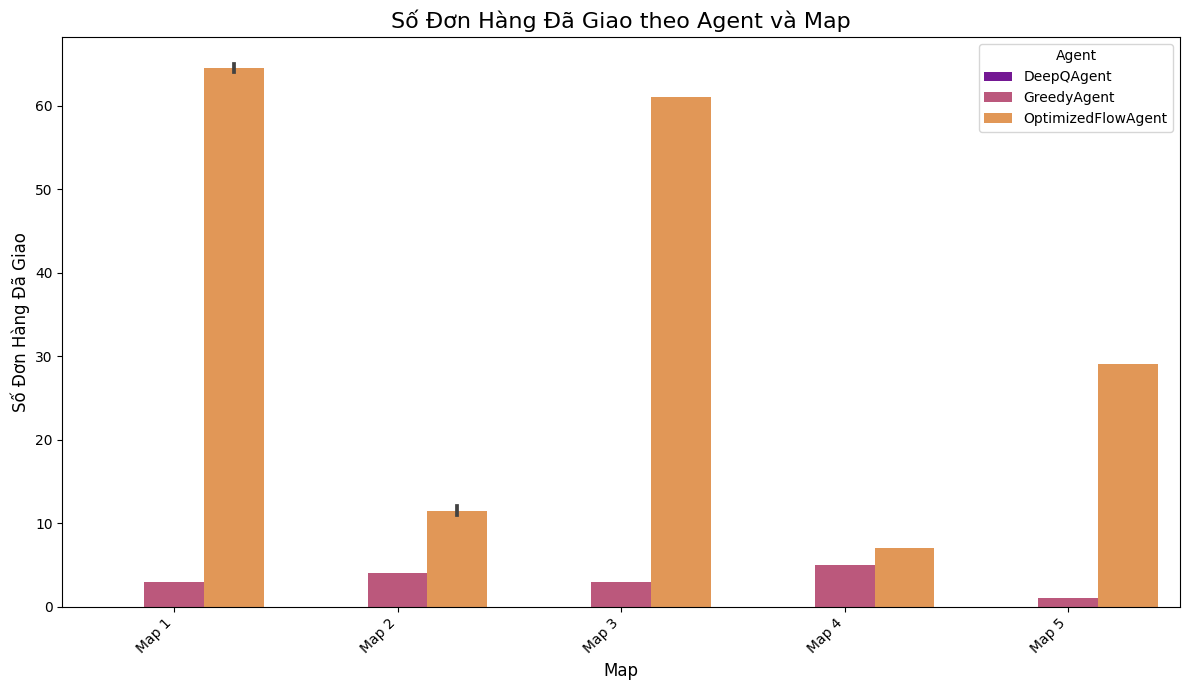


Trực quan hóa kết quả đã hoàn tất.


In [12]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns

results_file_path = "/kaggle/working/results.csv"

if os.path.exists(results_file_path):
    print(f"Đọc nội dung từ file: {results_file_path}\n")
    try:
        df_results = pd.read_csv(results_file_path)

        print("Dữ liệu từ results.csv:")
        df_display = df_results.copy()
        df_display['Map'] = df_display['Map'].apply(lambda x: os.path.basename(x).replace('.txt', '').replace('map', 'Map '))
        df_display = df_display.drop(columns=['Num_Agents', 'Num_Packages'])
        print(df_display.to_markdown(index=False))
        
        print("Bắt đầu trực quan hóa kết quả...")
        df_results['Map_Name'] = df_results['Map'].apply(lambda x: os.path.basename(x).replace('.txt', '').replace('map', 'Map '))
        df_results_sorted = df_results.sort_values(by=['Map_Name', 'Agent'])
        plt.figure(figsize=(12, 7))
        sns.barplot(x='Map_Name', y='Delivered_Packages', hue='Agent', data=df_results_sorted, palette='plasma')
        plt.title('Số Đơn Hàng Đã Giao theo Agent và Map', fontsize=16)
        plt.xlabel('Map', fontsize=12)
        plt.ylabel('Số Đơn Hàng Đã Giao', fontsize=12)
        plt.xticks(rotation=45, ha='right')
        plt.legend(title='Agent')
        plt.tight_layout()
        plt.show()
        print("\nTrực quan hóa kết quả đã hoàn tất.")

    except Exception as e:
        print(f"Lỗi khi đọc hoặc trực quan hóa file CSV: {e}")
else:
    print(f"File '{results_file_path}' không tồn tại. Vui lòng đảm bảo code đã chạy và tạo file.")
